In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

W tym zeszycie rozpatrzymy zależności między uwarunkowaniami biologicznymi (tj. wzrostem, wagą, wiekiem i narodowością) a grą w NBA. Przedmiotem analizy będzie 23 kompletnych sezonów w XXI wieku, począwszy od sezonu 1999-2000 aż do sezonu 2021-2022. Dla każdego sezonu dostępne są cztery ramki danych: dane osobiste (bios), statystyki łączne (totals), statystyki średnie na mecz (per_game) i statystyki średnie na minutę (per_minute)

Pobrane ramki danych wyrażają wzrost w stopach i calach, a wagę w funtach. Poniższe funkcje służą do konwersji tych danych na centymetry i kilogramy.

In [2]:
def convert_to_cm(height):
    CENTIMETERS_IN_FOOT = 30.48
    CENTIMETERS_IN_INCH = 2.54
    feet, inches = height.split('-')
    total_cm = CENTIMETERS_IN_FOOT * int(feet) + CENTIMETERS_IN_INCH * int(inches)
    return round(total_cm, 1)

def convert_to_kg(weight):
    KILOGRAMS_IN_POUND = 0.4536
    return round(KILOGRAMS_IN_POUND * int(weight), 1)

In [3]:
dataframes = {}
YEAR_FROM = 2000
YEAR_TO = 2022

for year in range(YEAR_FROM, YEAR_TO + 1):
    bios_file = f'DataFrames\\Bios\\bios_{year}.csv'
    bios = pd.read_csv(bios_file, index_col='Player')
    bios = bios.drop('GP', axis=1)
    bios['HT'] = bios['HT'].apply(convert_to_cm)
    bios['WT'] = bios['WT'].apply(convert_to_kg)
    dataframes["bios", year] = bios

    totals_file = f'DataFrames\\Totals\\totals_{year}.csv'
    totals = pd.read_csv(totals_file, index_col='Player')
    dataframes["totals", year] = totals

    per_game_file = f'DataFrames\\Averages\\averages_{year}.csv'
    per_game = pd.read_csv(per_game_file, index_col='Player')
    dataframes["per_game", year] = per_game

    per_minute_file = f'DataFrames\\PerMinute\\per_minute_{year}.csv'
    per_minute = pd.read_csv(per_minute_file, index_col='Player')
    dataframes["per_minute", year] = per_minute

Poniżej przedstawiono liczbę graczy dla każdego sezonu i każdej kategorii

In [4]:
years = list(range(YEAR_FROM, YEAR_TO+1))
presentation = pd.DataFrame({'bios': {year: dataframes["bios", year].shape[0] for year in years},
                            'totals': {year: dataframes["totals", year].shape[0] for year in years},
                            'per_game': {year: dataframes["per_game", year].shape[0] for year in years},
                            'per_minute': {year: dataframes["per_minute", year].shape[0] for year in years},
                            })
display(presentation)

,bios,totals,per_game,per_minute
2000,439,439,439,439
2001,441,441,441,441
2002,440,440,440,440
2003,428,428,428,428
2004,442,442,442,442
2005,464,464,464,464
2006,458,458,458,458
2007,458,458,458,458
2008,451,451,451,451
2009,445,445,445,445


Łączna liczba analizowanych koszykarzy wynosi:

In [5]:
all_players_all_seasons = pd.concat([dataframes["bios", year] for year in years])
unique_players = all_players_all_seasons.reset_index().drop_duplicates(subset=all_players_all_seasons.index.name).set_index("Player")
display(len(unique_players))

2252

W celu łatwiejszego operowania na danych, poniższe komórki tworzą ramki danych dla każdej kategorii złożone z wszystkich sezonów (jeden rekord dla każdego zawodnika w każdym sezonie)

In [6]:
all_seasons_totals = pd.merge(dataframes["bios", YEAR_FROM], dataframes["totals", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_totals = pd.concat([all_seasons_totals, pd.merge(dataframes["bios", year], dataframes["totals", year], on='Player')])
display(all_seasons_totals)

,Pos,HT,WT,Age,Teams,YOS,Pre-Draft Team,Draft Status,Nationality,#,...,FTA,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF
Player,,,,,,,,,,,,,,,,,,,,,
Tariq Abdul-Wahad,SF,198.1,101.2,25,"DEN, ORL",2,San Jose State,1997 Rnd 1 Pick 11,France,128,...,193,0.756,101,190,291,98,59,28,106,147
Shareef Abdur-Rahim,F,205.7,102.1,23,VAN,3,California,1996 Rnd 1 Pick 3,United States,16,...,551,0.809,218,607,825,271,89,87,249,244
Cory Alexander,G,185.4,83.9,26,DEN,4,Virginia,1995 Rnd 1 Pick 29,United States,352,...,22,0.773,8,34,42,58,24,2,28,39
Ray Allen,SG,195.6,93.0,24,MIL,3,Connecticut,1996 Rnd 1 Pick 5,United States,11,...,398,0.887,83,276,359,308,110,19,183,187
Rafer Alston,G,188.0,79.4,23,MIL,0,Fresno State,1998 Rnd 2 Pick 10,United States,366,...,4,0.750,5,18,23,70,12,0,29,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thaddeus Young,F,203.2,106.6,33,"SAN, TOR",14,Georgia Tech,2007 Rnd 1 Pick 12,United States,300,...,49,0.469,80,128,208,104,54,18,52,81
Trae Young,PG,185.4,81.6,23,ATL,3,Oklahoma,2018 Rnd 1 Pick 5,United States,1,...,553,0.904,50,234,284,737,72,7,303,128
Omer Yurtseven,C,210.8,115.7,23,MIA,1,Georgetown,"2020 NBA Draft, Undrafted",Uzbekistan Turkey,312,...,61,0.623,85,209,294,49,17,20,41,84


In [7]:
all_seasons_per_game = pd.merge(dataframes["bios", YEAR_FROM], dataframes["per_game", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_per_game = pd.concat([all_seasons_per_game, pd.merge(dataframes["bios", year], dataframes["per_game", year], on='Player')])
display(all_seasons_per_game)

,Pos,HT,WT,Age,Teams,YOS,Pre-Draft Team,Draft Status,Nationality,#,...,FTA,FT%,ORB,DRB,RPG,APG,SPG,BPG,TOV,PF
Player,,,,,,,,,,,,,,,,,,,,,
Tariq Abdul-Wahad,SF,198.1,101.2,25,"DEN, ORL",2,San Jose State,1997 Rnd 1 Pick 11,France,111,...,3.2,0.756,1.7,3.1,4.8,1.6,1.0,0.5,1.7,2.4
Shareef Abdur-Rahim,F,205.7,102.1,23,VAN,3,California,1996 Rnd 1 Pick 3,United States,18,...,6.7,0.809,2.7,7.4,10.1,3.3,1.1,1.1,3.0,3.0
Cory Alexander,G,185.4,83.9,26,DEN,4,Virginia,1995 Rnd 1 Pick 29,United States,348,...,0.8,0.773,0.3,1.2,1.4,2.0,0.8,0.1,1.0,1.3
Ray Allen,SG,195.6,93.0,24,MIL,3,Connecticut,1996 Rnd 1 Pick 5,United States,14,...,4.9,0.887,1.0,3.4,4.4,3.8,1.3,0.2,2.2,2.3
Rafer Alston,G,188.0,79.4,23,MIL,0,Fresno State,1998 Rnd 2 Pick 10,United States,379,...,0.1,0.750,0.2,0.7,0.9,2.6,0.4,0.0,1.1,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thaddeus Young,F,203.2,106.6,33,"SAN, TOR",14,Georgia Tech,2007 Rnd 1 Pick 12,United States,332,...,0.9,0.469,1.5,2.5,4.0,2.0,1.0,0.3,1.0,1.6
Trae Young,PG,185.4,81.6,23,ATL,3,Oklahoma,2018 Rnd 1 Pick 5,United States,6,...,7.3,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7
Omer Yurtseven,C,210.8,115.7,23,MIA,1,Georgetown,"2020 NBA Draft, Undrafted",Uzbekistan Turkey,374,...,1.1,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5


In [8]:
all_seasons_per_minute = pd.merge(dataframes["bios", YEAR_FROM], dataframes["per_minute", YEAR_FROM], on='Player')
for year in range(YEAR_FROM + 1, YEAR_TO + 1):
    all_seasons_per_minute = pd.concat([all_seasons_per_minute, pd.merge(dataframes["bios", year], dataframes["per_minute", year], on='Player')])
display(all_seasons_per_minute)

,Pos,HT,WT,Age,Teams,YOS,Pre-Draft Team,Draft Status,Nationality,#,...,FTA,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF
Player,,,,,,,,,,,,,,,,,,,,,
Tariq Abdul-Wahad,SF,198.1,101.2,25,"DEN, ORL",2,San Jose State,1997 Rnd 1 Pick 11,France,102,...,0.1,0.756,0.1,0.1,0.2,0.1,0.0,0.0,0.1,0.1
Shareef Abdur-Rahim,F,205.7,102.1,23,VAN,3,California,1996 Rnd 1 Pick 3,United States,37,...,0.2,0.809,0.1,0.2,0.3,0.1,0.0,0.0,0.1,0.1
Cory Alexander,G,185.4,83.9,26,DEN,4,Virginia,1995 Rnd 1 Pick 29,United States,355,...,0.1,0.773,0.0,0.1,0.1,0.2,0.1,0.0,0.1,0.1
Ray Allen,SG,195.6,93.0,24,MIL,3,Connecticut,1996 Rnd 1 Pick 5,United States,11,...,0.1,0.887,0.0,0.1,0.1,0.1,0.0,0.0,0.1,0.1
Rafer Alston,G,188.0,79.4,23,MIL,0,Fresno State,1998 Rnd 2 Pick 10,United States,419,...,0.0,0.750,0.0,0.0,0.1,0.2,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thaddeus Young,F,203.2,106.6,33,"SAN, TOR",14,Georgia Tech,2007 Rnd 1 Pick 12,United States,317,...,0.1,0.469,0.1,0.2,0.2,0.1,0.1,0.0,0.1,0.1
Trae Young,PG,185.4,81.6,23,ATL,3,Oklahoma,2018 Rnd 1 Pick 5,United States,11,...,0.2,0.904,0.0,0.1,0.1,0.3,0.0,0.0,0.1,0.0
Omer Yurtseven,C,210.8,115.7,23,MIA,1,Georgetown,"2020 NBA Draft, Undrafted",Uzbekistan Turkey,234,...,0.1,0.623,0.1,0.3,0.4,0.1,0.0,0.0,0.1,0.1


Przy opracowywaniu wyników komórki będą korzystać z poniżej funkcji get_normalized_dataframe, aby zwiększyć wiarygodność wyników. Funkcja usuwa z ramki danych kolumny, w których liczba wartości NaN jest mniejsza od określonego minimum.

In [9]:
def get_normalized_dataframe(dframe, minimum = 50):
    mask = dframe.count() <= minimum
    return dframe.drop(columns=dframe.columns[mask])

Przykładowo, rozpatrzymy ramkę danych, w której kolumny są wiekiem zawodnika, rzędy kolejnymi zawodnikami, a wartościami jest liczba minut, którą dany zawodnik rozegrał w sezonie w danym wieku. Korzystając z ramki chcemy obliczyć średnią liczbę minut, jaką zawodnicy rozgrywają w sezonie w danym wieku.

In [10]:
total_games_to_age = pd.pivot_table(all_seasons_totals, values='GP', index='Player', columns='Age')
print(total_games_to_age[[38, 39]].dropna(how='all'))

Age                 38    39
Player                      
Alonzo Mourning   25.0   NaN
Anderson Varejao   5.0   NaN
Andre Iguodala    31.0   NaN
Andre Miller      81.0  39.0
Antoine Carr      21.0   NaN
...                ...   ...
Terry Porter      72.0   NaN
Tim Duncan        77.0  61.0
Tyrone Corbin     15.0   NaN
Udonis Haslem     10.0   4.0
Vince Carter      66.0  60.0

[70 rows x 2 columns]


TODO: statystyki powodujące przejście na emeryturę - w jakim momencie gracz jest już za słaby

w jakim tempie spada coś z sezonu na sezon

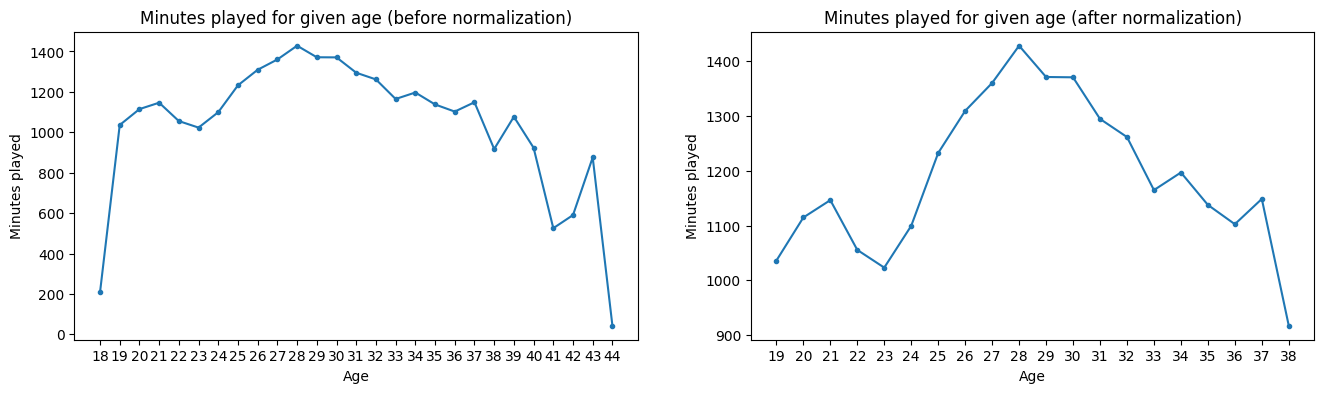

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

total_minutes_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[0].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[0].set_title('Minutes played for given age (before normalization)')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Minutes played')
ax[0].set_xticks(avrg_total_minutes_to_age.index)

total_minutes_to_age = get_normalized_dataframe(total_minutes_to_age)
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[1].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[1].set_title('Minutes played for given age (after normalization)')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Minutes played')
ax[1].set_xticks(avrg_total_minutes_to_age.index)

plt.show()

Na wykresie korzystającym z danych przed normalizacją odnotowano gwałtowany wzrost średniej liczby rozegranych minut na sezon w wieku 43 lat. Średnia ta jest porównywalna z liczbą minut dla wieku 38, a więc dla zawodników o 5 lat młodszych. Jest to spowodowane faktem, że tylko jeden zawodnik w historii NBA rozegrał sezon w tym wieku - był to Vince Carter, który w sezonie 2019-20, w wieku 43 lat, rozegrał ponad 875 minut w 60 meczach.

W celu wiarygodnego przedstawiania statystyk wykorzystam do normalizacji funkcję get_normalized_dataframe, która odrzuci kolumny o zbyt małej liczbie danych. Tak przerobiona ramka jest przedstawiona na prawym wykresie - przedstawione są statystyki tylko dla tych wieków zawodników, w jakich przynajmniej 50 zawodników w historii NBA rozegrało sezon.

Oczywiście wykres nie pokazuje jeszcze w pełni wyraźnie, że z upływem lat zawodnik rozgrywa coraz mniej minut - wciąż można zaobserwować wzrost tej liczby w wieku 39 lat, mimo normalizacji. Jest to spowodowane tym, że zawodnik grający w NBA w wieku 39 lat jest najprawdopodobniej cenny dla zespołu (w przeciwnym wypadku byłby już na emeryturze). Stąd mimo że fizyczna wydajność zawodników spada z wiekiem, zawodnicy tacy jak Dirk Nowitzki, Karl Malone, Michael Jordan, czy Tim Duncan wciąż byli w stanie osiągnąć ponad 60 meczy w sezonie w wieku 39 lat (nie bez powodu każdy z wymienionych był nagradzany nagrodną MVP i był ponad 10 razy wybierany do NBA All-Star)

    Teraz nastąpi właściwa analiza danych.

Najpierw przeanalizuję zależność wieku od wyników w ciągu sezonu. Badana będzie konkretnie korelacja między wiekiem a:

- Liczbą rozgrywanych minut i meczy na sezon

- Liczbą punktów, zbiórek, asyst i strat na sezon

- Celnością rzutów z gry, za trzy punkty i rzutów osobistych na sezon

- Liczbą fauli na sezon



    Zależności wiek - mecze/minuty

Jeśli chodzi o zależność między liczbą rozgrywanych minut i meczy na sezon od wieku, można spodziewać się, że statystyka ta jest silnie skorelowana. Średnia liczba meczy i minut w sezonie powinna od samego początku rosnąć (młodzi zawodnicy zyskują doświadczenie, dostosowują się do realiów gry w NBA), a zacząć spadać po szczycie ficznej formy zawodnika, który przypada około 28 roku (ta statystyka będzie później pokazana)

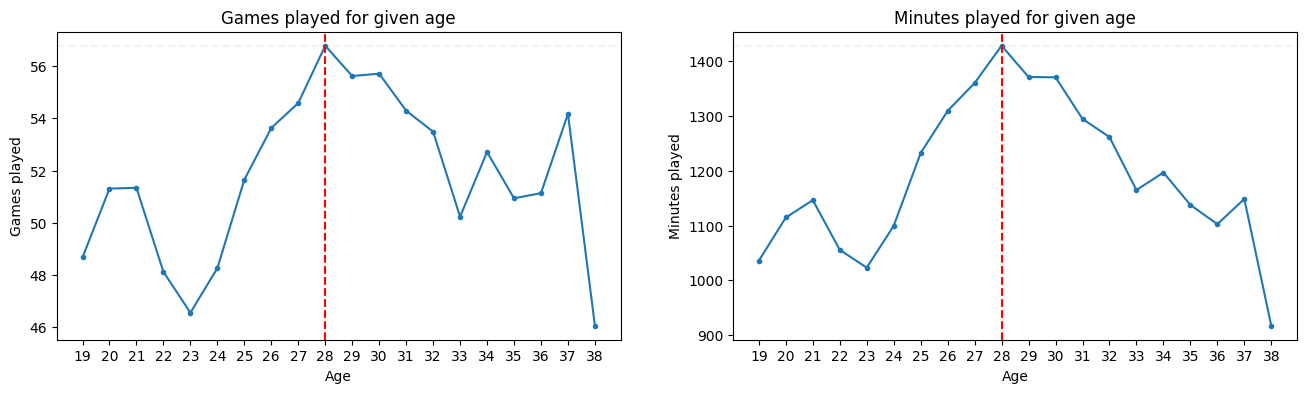

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))


total_games_to_age = pd.pivot_table(all_seasons_totals, values='GP', index='Player', columns='Age')
total_games_to_age = get_normalized_dataframe(total_games_to_age)
avrg_total_games_to_age = total_games_to_age.mean()
ax[0].plot(avrg_total_games_to_age.index, avrg_total_games_to_age.values, label='Average games played in a season',  marker='.')
ax[0].set_title('Games played for given age')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Games played')
ax[0].set_xticks(avrg_total_games_to_age.index)
ax[0].axvline(avrg_total_games_to_age.idxmax(), color='r', linestyle='--')
ax[0].axhline(avrg_total_games_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.1)

total_minutes_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
total_minutes_to_age = get_normalized_dataframe(total_minutes_to_age)
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax[1].plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes played in a season',  marker='.')
ax[1].set_title('Minutes played for given age')
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Minutes played')
ax[1].set_xticks(avrg_total_minutes_to_age.index)
ax[1].axvline(avrg_total_minutes_to_age.idxmax(), color='r', linestyle='--')
ax[1].axhline(avrg_total_minutes_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.1)


plt.show()

Na wykresach widać, że średnia liczba meczy i minut na sezon rzeczywiście rośnie od 23 roku życia i zaczyna spadać po 28 roku życia, w którym następuje szczyt fizycznych możliwości zawodnika. Widać jednak, że średnia liczba minut na sezon jest dużo podatniejsza na starzenie - od 28 do 37 roku życia maleje niemal liniowo. Tego samego nie można powiedzieć o liczbie meczy, co nie powinno być dużym zaskoczeniem - zawodnik może wejść na boisko na ledwie parę minut, a mecz wciąż zostanie dodany do tej statystyki. Tę hipotezę potwierdza poniższy wykres, ukazujący zależność między wiekiem i średnią liczbą minut rozgrywaną na mecz.

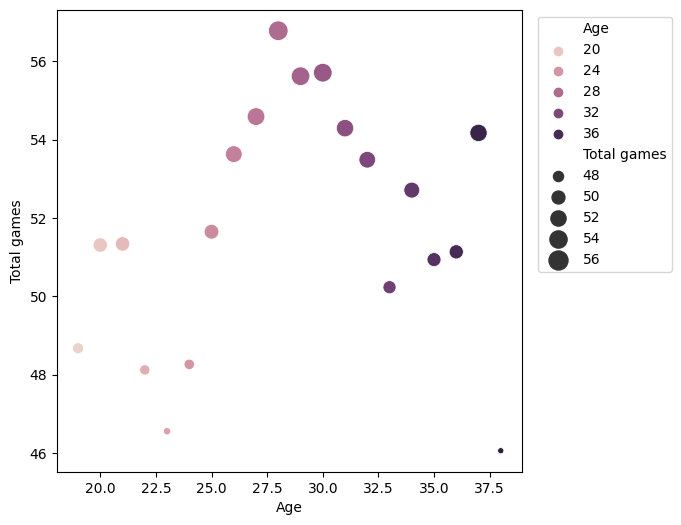

In [13]:
"""plt.figure(figsize=(6,6))
sns.scatterplot(
    x='GDP per capita',
    y='happiness',
    data=dane,
    hue='happiness',
    size='GDP per capita',
    sizes=(20, 200),
    legend='brief',
)
plt.show()"""

result = avrg_total_games_to_age.reset_index()
result.columns = ['Age', 'Total games']
#display(result)

plt.figure(figsize=(6,6))
sns.scatterplot(
    x='Age',
    y='Total games',
    data=result,
    hue='Age',
    size='Total games',
    sizes=(20, 200),
)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
plt.show()

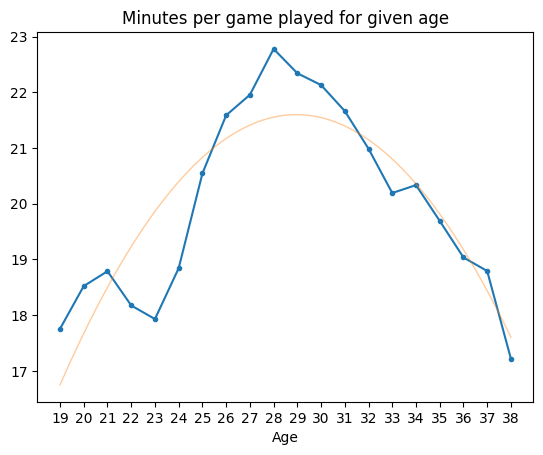

In [14]:
fig, ax = plt.subplots()

minutes_per_game_to_age = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='Age')
minutes_per_game_to_age = get_normalized_dataframe(minutes_per_game_to_age)
avrg_minutes_per_game_to_age = minutes_per_game_to_age.mean()
ax.plot(avrg_minutes_per_game_to_age.index, avrg_minutes_per_game_to_age.values, label='Minutes per game', marker='.')
ax.set_title('Minutes per game played for given age')
ax.set_xlabel('Age')

model_lin = LinearRegression()
X = avrg_minutes_per_game_to_age.index.values
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_minutes_per_game_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
ax.plot(X_test, Y_pred, linewidth=1, alpha=0.4)

plt.xticks(avrg_minutes_per_game_to_age.index)
plt.show()

Widać wyraźnie, że średnia liczba rozgrywanych minut na mecz wzrasta do 28 roku życia, a następnie maleje. Aby zależność była jeszcze bardziej oczywista, na poniższym wykresie przedstawiono zmiany w liczbie rozgrywanych minut w stosunku do statystyk, gdy gracz był rok młodszy (innymi słowy, wartość w wieku x f(x) = f(x) / f(x-1) ). Następnie dla każdego wieku obliczono średnią zmianę liczby rozgrywanych minut.

In [15]:
games_to_age = pd.pivot_table(all_seasons_totals, values='GP', index='Player', columns='Age')
display(games_to_age)

Age,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,82.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Bramlett,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Guyton,NaN,NaN,NaN,NaN,NaN,33.0,45.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Hammons,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Price,NaN,NaN,NaN,NaN,NaN,56.0,50.0,44.0,57.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zion Williamson,NaN,24.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoran Dragic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoran Planinic,NaN,NaN,NaN,49.0,43.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


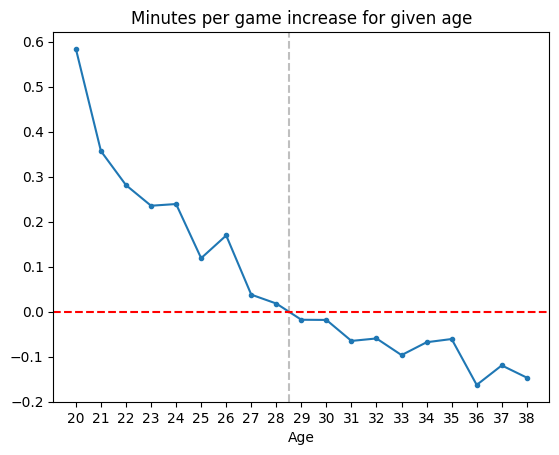

In [16]:
fig, ax = plt.subplots()

minutes_per_game_to_age = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='Age')
minutes_per_game_to_age = get_normalized_dataframe(minutes_per_game_to_age)
avrg_minutes_per_game_to_age_increase = minutes_per_game_to_age.iloc[:, 1:].div(minutes_per_game_to_age.shift(axis=1).iloc[:, 1:])
avrg_minutes_per_game_to_age_increase = avrg_minutes_per_game_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1
ax.plot(avrg_minutes_per_game_to_age_increase.index, avrg_minutes_per_game_to_age_increase.values, label='Minutes per game increase', marker='.')
ax.set_title('Minutes per game increase for given age')
ax.set_xlabel('Age')
ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
plt.xticks(avrg_minutes_per_game_to_age_increase.index)
plt.show()

Ponownie widać, że do około 28 roku życia średnia liczba rozgrywanych minut na mecz rośnie, jednak tempo tego przyrostu maleje. Średnia zmiana po osiągnięciu 29 jest zawsze ujemna, co oznacza, że przeciętny zawodnik z roku na rok rozgrywa coraz mniej minut na mecz. 

    Zależności wiek - punkty/zbiórki/asysty

In [17]:
average_points_to_age = pd.pivot_table(all_seasons_per_game, values='PPG', index='Player', columns='Age')
average_points_to_age = get_normalized_dataframe(average_points_to_age).mean()
average_rebounds_to_age = pd.pivot_table(all_seasons_per_game, values='RPG', index='Player', columns='Age')
average_rebounds_to_age = get_normalized_dataframe(average_rebounds_to_age).mean()
average_assists_to_age = pd.pivot_table(all_seasons_per_game, values='APG', index='Player', columns='Age')
average_assists_to_age = get_normalized_dataframe(average_assists_to_age).mean()

Będąc na parkiecie, koszkarz może wspomagać swój zespół w kilku aspektach, z których najważniejsze to: punkty, zbiórki i asysty. Mimo że różni koszykarze specjalizują się w innych aspektach gry, w XXI wieku od niemal każdego zawodnika oczekuje się, że będzie zdobywał punkty. Innymi słowy, nie każda statystyka jest sobie równa. Pokazuje to poniższy wykres.

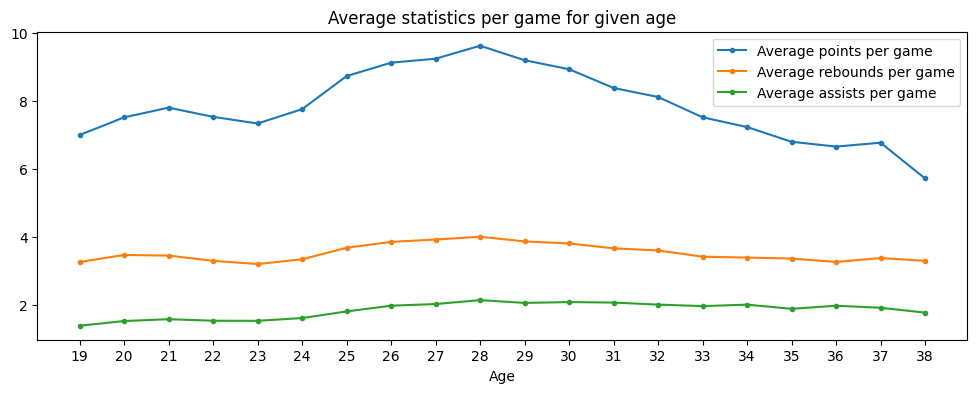

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(average_points_to_age.index, average_points_to_age.values, label='Average points per game',  marker='.')
ax.plot(average_rebounds_to_age.index, average_rebounds_to_age.values, label='Average rebounds per game',  marker='.')
ax.plot(average_assists_to_age.index, average_assists_to_age.values, label='Average assists per game',  marker='.')
ax.set_title('Average statistics per game for given age')
ax.set_xlabel('Age')
ax.set_xticks(average_points_to_age.index)

plt.legend()
plt.show()

Bez względu na wiek, średnia liczba punktów na mecz zawodników jest ponad dwa razy większa niż liczba zbiórek na mecz, która jest około dwa razy większa od liczby asyst. Ze względu na skalę, na powyższym wykresie nie widać, w jakim wieku przeciętny zawodnik osiąga największą liczbę punktów, zbiórek i asyst. Te wartości zostały przedstawione poniżej.

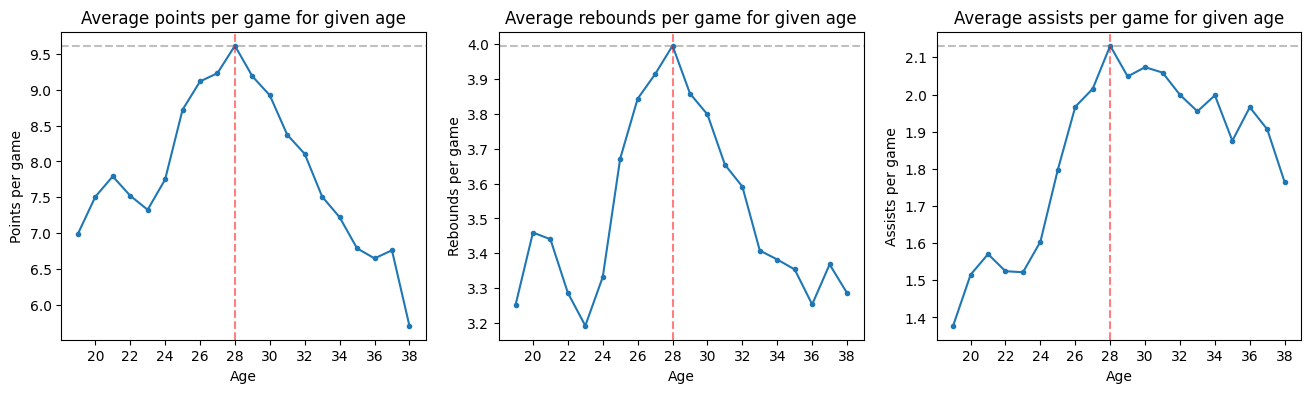

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

every_second_year = average_points_to_age.index.to_list()[1::2]

ax[0].plot(average_points_to_age.index, average_points_to_age.values,  marker='.')
ax[0].axvline(average_points_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[0].axhline(average_points_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Points per game')
ax[0].set_xticks(every_second_year)
ax[0].set_title('Average points per game for given age')

ax[1].plot(average_rebounds_to_age.index, average_rebounds_to_age.values,  marker='.')
ax[1].axvline(average_rebounds_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[1].axhline(average_rebounds_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Rebounds per game')
ax[1].set_xticks(every_second_year)
ax[1].set_title('Average rebounds per game for given age')

ax[2].plot(average_assists_to_age.index, average_assists_to_age.values, marker='.')
ax[2].axvline(average_assists_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[2].axhline(average_assists_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[2].set_xlabel('Age')
ax[2].set_ylabel('Assists per game')
ax[2].set_xticks(every_second_year)
ax[2].set_title('Average assists per game for given age')

plt.show()

Ponownie wiek 28 lat okazuje się być wiekiem, w którym przeciętny zawodnik osiąga najwyższe osiągi w wymienionych wyżej statystykach. Z wcześniejszych wykresów jednoznacznie wynika, że w wieku 28 lat zawodnicy średnio rozgrywają też największą liczbę meczy w sezonie, więc łączna liczba punktów, zbiórek i asyst w sezonie powinna być największa właśnie w tym wieku. 

In [20]:
total_points_to_age = pd.pivot_table(all_seasons_totals, values='PTS', index='Player', columns='Age')
total_points_to_age = get_normalized_dataframe(total_points_to_age).mean()
total_rebounds_to_age = pd.pivot_table(all_seasons_totals, values='REB', index='Player', columns='Age')
total_rebounds_to_age = get_normalized_dataframe(total_rebounds_to_age).mean()
total_assists_to_age = pd.pivot_table(all_seasons_totals, values='AST', index='Player', columns='Age')
total_assists_to_age = get_normalized_dataframe(total_assists_to_age).mean()

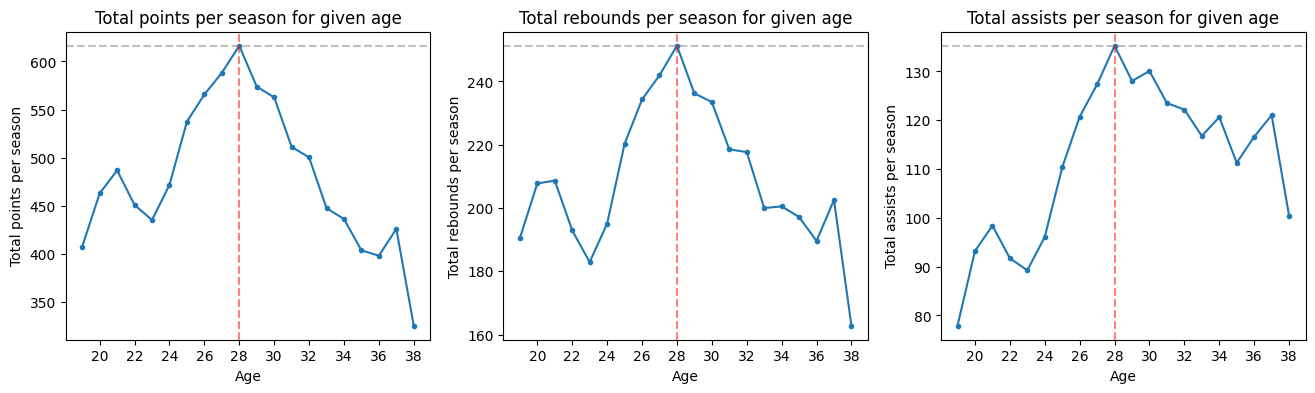

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

every_second_year = total_points_to_age.index.to_list()[1::2]

ax[0].plot(total_points_to_age.index, total_points_to_age.values,  marker='.')
ax[0].axvline(total_points_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[0].axhline(total_points_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Total points per season')
ax[0].set_xticks(every_second_year)
ax[0].set_title('Total points per season for given age')

ax[1].plot(total_rebounds_to_age.index, total_rebounds_to_age.values,  marker='.')
ax[1].axvline(total_rebounds_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[1].axhline(total_rebounds_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Total rebounds per season')
ax[1].set_xticks(every_second_year)
ax[1].set_title('Total rebounds per season for given age')

ax[2].plot(total_assists_to_age.index, total_assists_to_age.values, marker='.')
ax[2].axvline(total_assists_to_age.idxmax(), color='r', linestyle='--', alpha=0.5)
ax[2].axhline(total_assists_to_age.max(), color='gray', linestyle='--', label='max value', alpha=0.5)
ax[2].set_xlabel('Age')
ax[2].set_ylabel('Total assists per season')
ax[2].set_xticks(every_second_year)
ax[2].set_title('Total assists per season for given age')

plt.show()

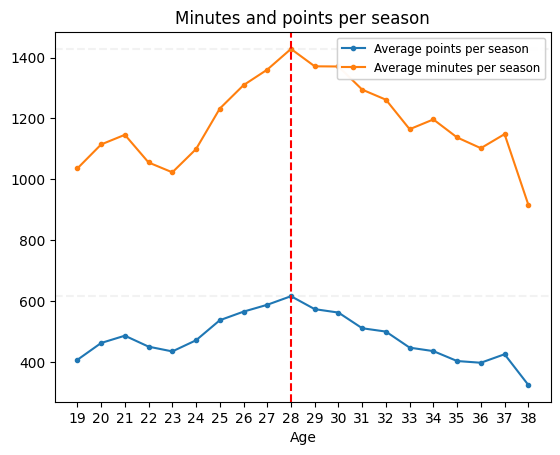

In [22]:
#punkt kulminacyjny
fig, ax = plt.subplots()

total_points_to_age = pd.pivot_table(all_seasons_totals, values='PTS', index='Player', columns='Age')
total_points_to_age = get_normalized_dataframe(total_points_to_age)
avrg_total_points_to_age = total_points_to_age.mean()
ax.plot(avrg_total_points_to_age.index, avrg_total_points_to_age.values, label='Average points per season',  marker='.')

total_minutes_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
total_minutes_to_age = get_normalized_dataframe(total_minutes_to_age)
avrg_total_minutes_to_age = total_minutes_to_age.mean()
ax.plot(avrg_total_minutes_to_age.index, avrg_total_minutes_to_age.values, label='Average minutes per season',  marker='.')

max_val1 = avrg_total_points_to_age.idxmax()
ax.axvline(max_val1, color='r', linestyle='--')

ax.set_title('Minutes and points per season')
ax.set_xlabel('Age')

max_points = avrg_total_points_to_age.max()
max_minutes = avrg_total_minutes_to_age.max()
ax.axhline(max_points, color='gray', linestyle='--', label='max value', alpha=0.1)
ax.axhline(max_minutes, color='gray', linestyle='--', label='max value', alpha=0.1)

lines = ax.legend().get_lines()
new_legend = ax.legend(handles=lines[:2], loc='upper right', fontsize='small')
ax.add_artist(new_legend)

plt.xticks(avrg_total_points_to_age.index)
plt.show()

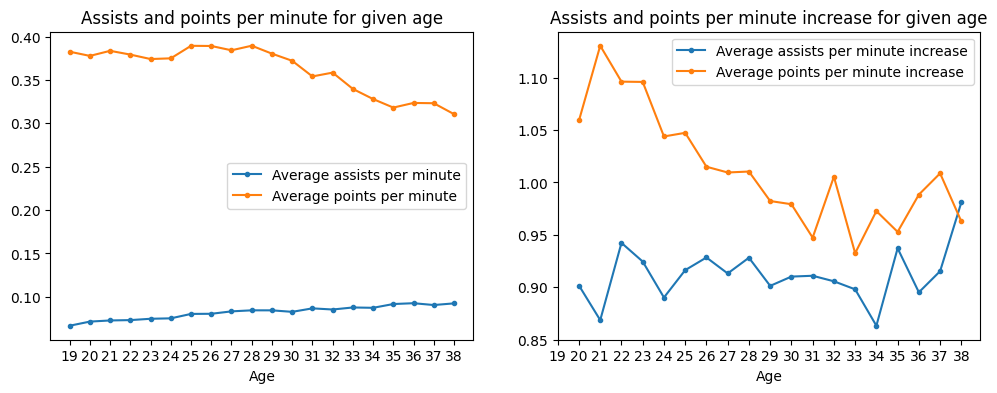

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.mean()
ax[0].plot(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, label='Average assists per minute',  marker='.')

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.mean()
ax[0].plot(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, label='Average points per minute',  marker='.')

ax[0].set_title('Assists and points per minute for given age')
ax[0].set_xlabel('Age')
ax[0].set_xticks(avrg_assists_per_minute_to_age.index)
ax[0].legend()


avrg_assists_per_minute_increase = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_increase = avrg_assists_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_assists_per_minute_increase.index, avrg_assists_per_minute_increase.values, label='Average assists per minute increase',  marker='.')

avrg_points_per_minute_increase = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_increase = avrg_points_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_points_per_minute_increase.index, avrg_points_per_minute_increase.values, label='Average points per minute increase',  marker='.')

ax[1].set_title('Assists and points per minute increase for given age')
ax[1].set_xlabel('Age')
ax[1].set_xticks(avrg_assists_per_minute_to_age.index)
ax[1].legend()

"""assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_to_age = avrg_assists_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, label='Average assists per minute',  marker='.')

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_to_age = avrg_points_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, label='Average points per minute',  marker='.')"""


plt.show()

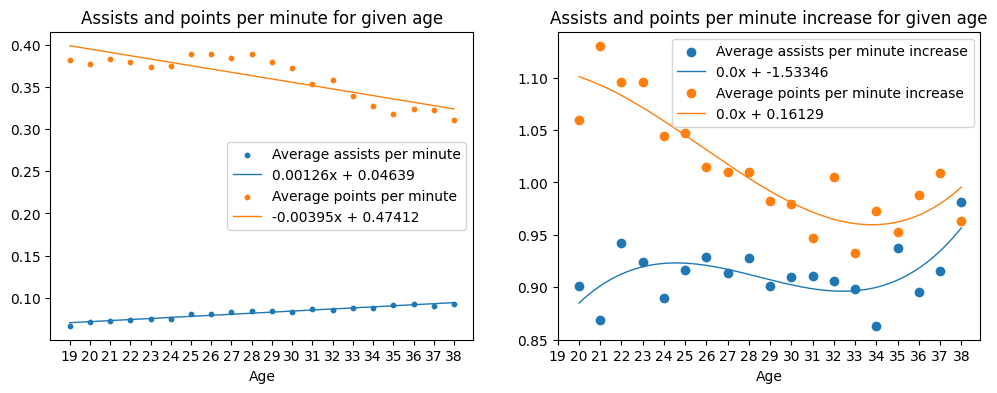

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.mean()
ax[0].scatter(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, s=10, label='Average assists per minute')
model_lin = LinearRegression()
X = avrg_assists_per_minute_to_age.index.values
model_lin.fit(X.reshape(-1,1), avrg_assists_per_minute_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.mean()
ax[0].scatter(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, s=10, label='Average points per minute')
model_lin = LinearRegression()
X = avrg_points_per_minute_to_age.index.values
model_lin.fit(X.reshape(-1,1), avrg_points_per_minute_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

ax[0].set_title('Assists and points per minute for given age')
ax[0].set_xlabel('Age')
ax[0].set_xticks(avrg_assists_per_minute_to_age.index)
ax[0].legend()


avrg_assists_per_minute_increase = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_increase = avrg_assists_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_assists_per_minute_increase.index, avrg_assists_per_minute_increase.values, label='Average assists per minute increase')
model_lin = LinearRegression()
X = avrg_assists_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_assists_per_minute_increase.values)
#model_lin.fit(X.reshape(-1,1), avrg_assists_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
#Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[1].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

avrg_points_per_minute_increase = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_increase = avrg_points_per_minute_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_points_per_minute_increase.index, avrg_points_per_minute_increase.values, label='Average points per minute increase')
model_lin = LinearRegression()
X = avrg_points_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_points_per_minute_increase.values)
#model_lin.fit(X.reshape(-1,1), avrg_points_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
#Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[1].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

ax[1].set_title('Assists and points per minute increase for given age')
ax[1].set_xlabel('Age')
ax[1].set_xticks(avrg_assists_per_minute_to_age.index)
ax[1].legend()

"""assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_to_age = avrg_assists_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_assists_per_minute_to_age.index, avrg_assists_per_minute_to_age.values, label='Average assists per minute',  marker='.')

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_to_age = avrg_points_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()
ax[1].plot(avrg_points_per_minute_to_age.index, avrg_points_per_minute_to_age.values, label='Average points per minute',  marker='.')"""


plt.show()

    Punkty

Zostało już ustalone, że około 28 roku życia przeciętny zawodnik osiąga szczyt swojej formy, w tym dorobku punktowego. Jednak wiek wpływa na znacznie więcej, niż tylko liczba punktów (taka jest hipoteza). Zmianie powinny ulegać także sumaryczna liczba prób zdobycia punktów oraz procentowa skuteczność rzutów.

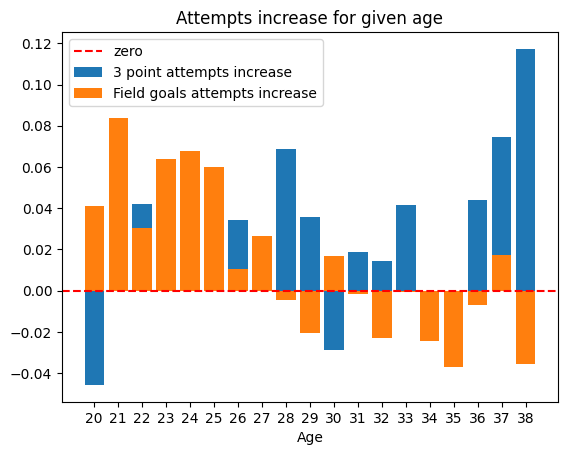

In [25]:
fig, ax = plt.subplots()

_3pts_attempts_to_age = pd.pivot_table(all_seasons_per_minute, values='3PA', index='Player', columns='Age')
_3pts_attempts_to_age = get_normalized_dataframe(_3pts_attempts_to_age)
_3pts_attempts_to_age_increase = _3pts_attempts_to_age.iloc[:, 1:].div(_3pts_attempts_to_age.shift(axis=1).iloc[:, 1:])
_3pts_attempts_to_age_increase = _3pts_attempts_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

_field_goals_attempts_to_age = pd.pivot_table(all_seasons_per_minute, values='FGA', index='Player', columns='Age')
_field_goals_attempts_to_age = get_normalized_dataframe(_field_goals_attempts_to_age)
_2pts_attempts_to_age = _field_goals_attempts_to_age - _3pts_attempts_to_age
_2pts_attempts_to_age_increase = _2pts_attempts_to_age.iloc[:, 1:].div(_2pts_attempts_to_age.shift(axis=1).iloc[:, 1:])
_2pts_attempts_to_age_increase = _2pts_attempts_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

ax.bar(_3pts_attempts_to_age_increase.index, _3pts_attempts_to_age_increase.values, label='3 point attempts increase')
ax.bar(_2pts_attempts_to_age_increase.index, _2pts_attempts_to_age_increase.values, label='Field goals attempts increase')

ax.set_title('Attempts increase for given age')
ax.set_xlabel('Age')
#ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
plt.xticks(_3pts_attempts_to_age_increase.index)
plt.legend()
plt.show()

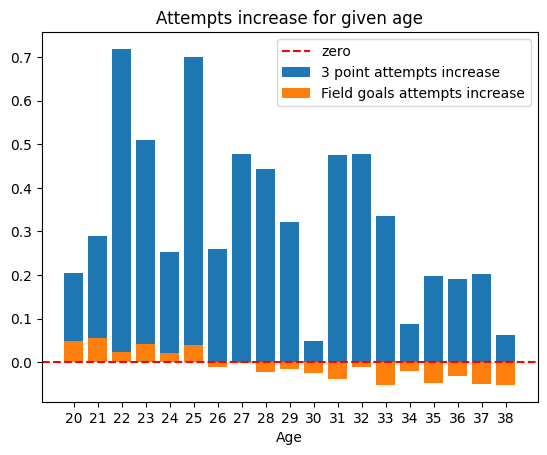

In [26]:
fig, ax = plt.subplots()

_total_minutes_played_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')
total_3pts_attempts_to_age = pd.pivot_table(all_seasons_totals, values='3PA', index='Player', columns='Age')

total_field_goals_attempts_to_age = pd.pivot_table(all_seasons_totals, values='FGA', index='Player', columns='Age')
_2pts_attempts_per_minute_to_age = (total_field_goals_attempts_to_age - total_3pts_attempts_to_age) / _total_minutes_played_to_age
_2pts_attempts_per_minute_to_age = get_normalized_dataframe(_2pts_attempts_per_minute_to_age)
_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age.iloc[:, 1:].div(_2pts_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

_3pts_attempts_per_minute_to_age = total_3pts_attempts_to_age / _total_minutes_played_to_age
_3pts_attempts_per_minute_to_age = get_normalized_dataframe(_3pts_attempts_per_minute_to_age)
_3pts_attempts_per_minute_to_age_increase = _3pts_attempts_per_minute_to_age.iloc[:, 1:].div(_3pts_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
_3pts_attempts_per_minute_to_age_increase = _3pts_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

ax.bar(_3pts_attempts_per_minute_to_age_increase.index, _3pts_attempts_per_minute_to_age_increase.values, label='3 point attempts increase')
ax.bar(_2pts_attempts_per_minute_to_age_increase.index, _2pts_attempts_per_minute_to_age_increase.values, label='Field goals attempts increase')

ax.set_title('Attempts increase for given age')
ax.set_xlabel('Age')
#ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
plt.xticks(_3pts_attempts_to_age_increase.index)
plt.legend()
plt.show()

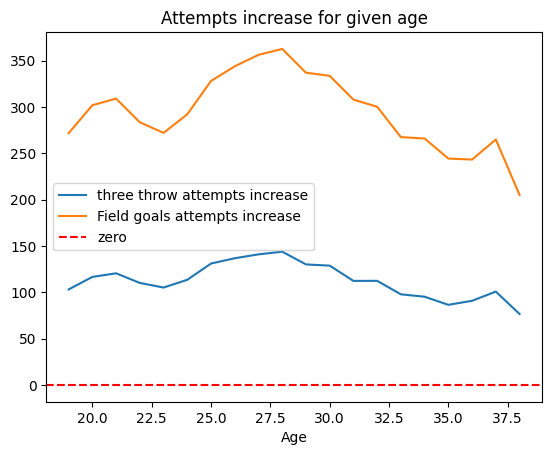

In [27]:
fig, ax = plt.subplots()

_total_minutes_played_to_age = pd.pivot_table(all_seasons_totals, values='MIN', index='Player', columns='Age')

total_field_goals_attempts_to_age = pd.pivot_table(all_seasons_totals, values='FGA', index='Player', columns='Age')
_2pts_attempts_per_minute_to_age = (total_field_goals_attempts_to_age - total_3pts_attempts_to_age)
_2pts_attempts_per_minute_to_age = get_normalized_dataframe(_2pts_attempts_per_minute_to_age).mean()
#_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age.iloc[:, 1:].div(_2pts_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
#_2pts_attempts_per_minute_to_age_increase = _2pts_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

_free_throw_attempts_per_minute_to_age = pd.pivot_table(all_seasons_totals, values='FTA', index='Player', columns='Age')
_free_throw_attempts_per_minute_to_age = get_normalized_dataframe(_free_throw_attempts_per_minute_to_age).mean()
#_free_throw_attempts_per_minute_to_age_increase = _free_throw_attempts_per_minute_to_age.iloc[:, 1:].div(_free_throw_attempts_per_minute_to_age.shift(axis=1).iloc[:, 1:])
#_free_throw_attempts_per_minute_to_age_increase = _free_throw_attempts_per_minute_to_age_increase.replace([np.inf, -np.inf], np.nan).mean() - 1

ax.plot(_free_throw_attempts_per_minute_to_age.index, _free_throw_attempts_per_minute_to_age.values, label='three throw attempts increase')
ax.plot(_2pts_attempts_per_minute_to_age.index, _2pts_attempts_per_minute_to_age.values, label='Field goals attempts increase')

ax.set_title('Attempts increase for given age')
ax.set_xlabel('Age')
#ax.axvline(28.5, color='gray', linestyle='--', alpha=0.5)
ax.axhline(0, color='red', linestyle='--', label='zero', alpha=1)
#plt.xticks(_3pts_attempts_to_age_increase.index)
plt.legend()
plt.show()

Jak widać, do około 28 roku życia rośnie zarówno średnia liczba prób  ...

    Procentowa skuteczność

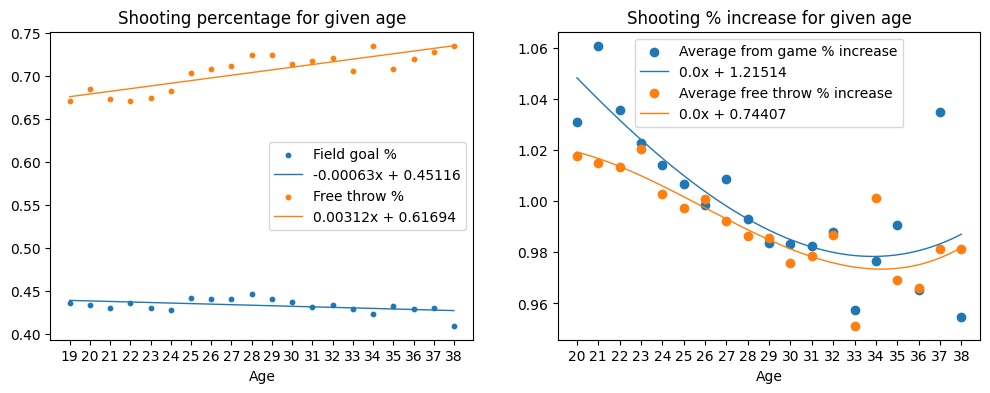

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

field_goal_percentage_to_age = pd.pivot_table(all_seasons_totals, values='FG%', index='Player', columns='Age')
field_goal_percentage_to_age = get_normalized_dataframe(field_goal_percentage_to_age)
average_field_goal_percentage_to_age = field_goal_percentage_to_age.mean()
ax[0].scatter(average_field_goal_percentage_to_age.index, average_field_goal_percentage_to_age.values, s=10, label='Field goal %')
model_lin = LinearRegression()
X = average_field_goal_percentage_to_age.index.values
model_lin.fit(X.reshape(-1,1), average_field_goal_percentage_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

free_throw_percentage_to_age = pd.pivot_table(all_seasons_per_minute, values='FT%', index='Player', columns='Age')
free_throw_percentage_to_age = get_normalized_dataframe(free_throw_percentage_to_age)
average_free_throw_percentage_to_age = free_throw_percentage_to_age.mean()
ax[0].scatter(average_free_throw_percentage_to_age.index, average_free_throw_percentage_to_age.values, s=10, label='Free throw %')
model_lin = LinearRegression()
X = average_free_throw_percentage_to_age.index.values
model_lin.fit(X.reshape(-1,1), average_free_throw_percentage_to_age.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[0].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

ax[0].set_title('Shooting percentage for given age')
ax[0].set_xlabel('Age')
ax[0].set_xticks(average_free_throw_percentage_to_age.index)
ax[0].legend()


field_goal_percentage_to_age_increase = field_goal_percentage_to_age.iloc[:, 1:].div(field_goal_percentage_to_age.shift(axis=1).iloc[:, 1:])
avrg_field_goal_percentage_to_age_increase = field_goal_percentage_to_age_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_field_goal_percentage_to_age_increase.index, avrg_field_goal_percentage_to_age_increase.values, label=r"Average from game % increase")
model_lin = LinearRegression()
X = avrg_field_goal_percentage_to_age_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_field_goal_percentage_to_age_increase.values)
#model_lin.fit(X.reshape(-1,1), avrg_assists_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
#Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[1].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

avrg_free_throw_percentage_to_age_increase = free_throw_percentage_to_age.iloc[:, 1:].div(free_throw_percentage_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_increase = avrg_free_throw_percentage_to_age_increase.replace([np.inf, -np.inf], np.nan).mean()
ax[1].scatter(avrg_points_per_minute_increase.index, avrg_points_per_minute_increase.values, label=r'Average free throw % increase')
model_lin = LinearRegression()
X = avrg_points_per_minute_increase.index.values
gen_features = PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)
model_lin.fit(gen_features.fit_transform(X.reshape(-1,1)), avrg_points_per_minute_increase.values)
#model_lin.fit(X.reshape(-1,1), avrg_points_per_minute_increase.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(gen_features.fit_transform(X_test.reshape(-1,1)))
#Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax[1].plot(X_test, Y_pred, linewidth=1, label=f"{np.round(model_lin.coef_,5)[0]}x + {np.round(model_lin.intercept_,5)}")

ax[1].set_title(f'Shooting % increase for given age')
ax[1].set_xlabel('Age')
ax[1].set_xticks(avrg_points_per_minute_increase.index)
ax[1].legend()

plt.show()

    Wzrost

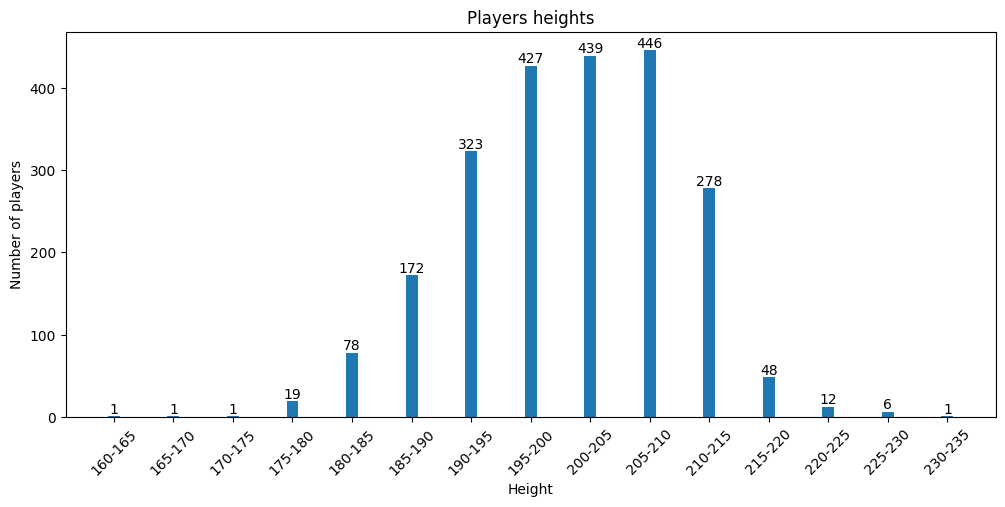

In [39]:
all_players_all_seasons_bios = pd.concat([dataframes["bios", year] for year in years])['HT']
all_nonduplicate_players_bios = all_players_all_seasons_bios.reset_index().drop_duplicates(subset=all_players_all_seasons_bios.index.name, keep="first").set_index("Player")
all_nonduplicate_players_bios = all_nonduplicate_players_bios["HT"]
heights = all_nonduplicate_players_bios.groupby(all_nonduplicate_players_bios.values).size()

range_boundaries = [ht for ht in range(int(heights.index[0]), int(heights.index[-1]+5), 5)]
bins = pd.cut(all_nonduplicate_players_bios.values, bins=range_boundaries, labels=range_boundaries[1:], include_lowest=True)
grouped = all_nonduplicate_players_bios.groupby(bins).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(12,5))

ax.bar(grouped["index"].values, grouped["count"].values, width=1)
ax.set_title('Players heights')
ax.set_xlabel('Height')
ax.set_ylabel('Number of players')
ax.set_xticks(grouped["index"].values,labels=[f"{ht-5}-{ht}" for ht in grouped["index"].values], rotation=45)

ax.bar_label(ax.containers[0], fmt='%d', label_type='edge')

plt.show()


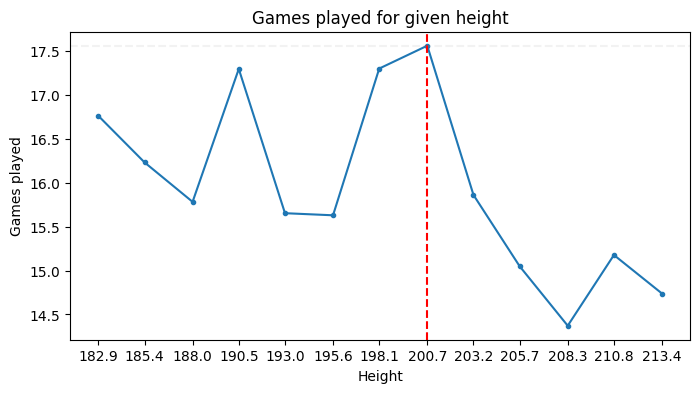

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

total_games_to_height = pd.pivot_table(all_seasons_per_game, values='MPG', index='Player', columns='HT')
total_games_to_height = get_normalized_dataframe(total_games_to_height)
avrg_total_games_to_height = total_games_to_height.mean()
ax.plot(avrg_total_games_to_height.index, avrg_total_games_to_height.values, label='Average games played in a season',  marker='.')
ax.set_title('Games played for given height')
ax.set_xlabel('Height')
ax.set_ylabel('Games played')
ax.set_xticks(avrg_total_games_to_height.index)
ax.axvline(avrg_total_games_to_height.idxmax(), color='r', linestyle='--')
ax.axhline(avrg_total_games_to_height.max(), color='gray', linestyle='--', label='max value', alpha=0.1)

plt.show()

In [73]:
average_points_to_height = pd.pivot_table(all_seasons_per_game, values='PPG', index='Player', columns='HT')
average_points_to_height = get_normalized_dataframe(average_points_to_height).mean()
average_rebounds_to_height = pd.pivot_table(all_seasons_per_game, values='RPG', index='Player', columns='HT')
average_rebounds_to_height = get_normalized_dataframe(average_rebounds_to_height).mean()
average_assists_to_height = pd.pivot_table(all_seasons_per_game, values='APG', index='Player', columns='HT')
average_assists_to_height = get_normalized_dataframe(average_assists_to_height).mean()
average_blocks_to_height = pd.pivot_table(all_seasons_per_game, values='BPG', index='Player', columns='HT')
average_blocks_to_height = get_normalized_dataframe(average_blocks_to_height).mean()

In [72]:
points_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='HT')
points_to_height_per_minute = get_normalized_dataframe(points_to_height_per_minute).mean()
rebounds_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='REB', index='Player', columns='HT')
rebounds_to_height_per_minute = get_normalized_dataframe(rebounds_to_height_per_minute).mean()
assists_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='HT')
assists_to_height_per_minute = get_normalized_dataframe(assists_to_height_per_minute).mean()
blocks_to_height_per_minute = pd.pivot_table(all_seasons_per_minute, values='BLK', index='Player', columns='HT')
blocks_to_height_per_minute = get_normalized_dataframe(blocks_to_height_per_minute).mean()

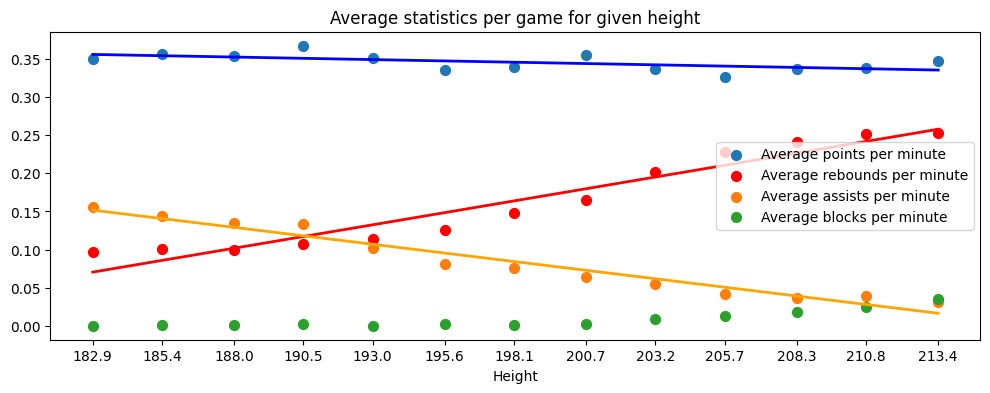

In [74]:
fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(points_to_height_per_minute.index, points_to_height_per_minute.values, label='Average points per minute',  marker='.', s=200)
ax.scatter(rebounds_to_height_per_minute.index, rebounds_to_height_per_minute.values, label='Average rebounds per minute',  marker='.', s=200, color='red')
ax.scatter(assists_to_height_per_minute.index, assists_to_height_per_minute.values, label='Average assists per minute',  marker='.', s=200)
ax.set_title('Average statistics per game for given height')
ax.set_xlabel('Height')
ax.set_xticks(average_assists_to_height.index)

model_lin = LinearRegression()
X = points_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), points_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='blue')

model_lin = LinearRegression()
X = rebounds_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), rebounds_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='red')

model_lin = LinearRegression()
X = assists_to_height_per_minute.index.values
model_lin.fit(X.reshape(-1,1), assists_to_height_per_minute.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='orange')

plt.legend()
plt.show()

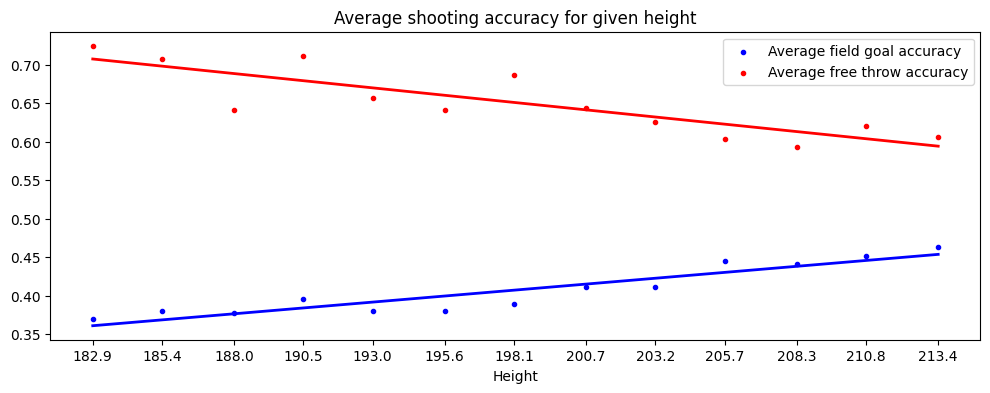

In [71]:
fig, ax = plt.subplots(figsize=(12,4))

field_goals_accuracy_to_height = pd.pivot_table(all_seasons_totals, values='FG%', index='Player', columns='HT')
field_goals_accuracy_to_height = get_normalized_dataframe(field_goals_accuracy_to_height).mean()

free_throw_accuracy_to_height = pd.pivot_table(all_seasons_totals, values='FT%', index='Player', columns='HT')
free_throw_accuracy_to_height = get_normalized_dataframe(free_throw_accuracy_to_height).mean()

ax.scatter(field_goals_accuracy_to_height.index, field_goals_accuracy_to_height.values, label='Average field goal accuracy',  marker='.', color='blue')
ax.scatter(free_throw_accuracy_to_height.index, free_throw_accuracy_to_height.values, label='Average free throw accuracy',  marker='.', color="red")
ax.set_title('Average shooting accuracy for given height')
ax.set_xlabel('Height')
ax.set_xticks(free_throw_accuracy_to_height.index)

model_lin = LinearRegression()
X = field_goals_accuracy_to_height.index.values
model_lin.fit(X.reshape(-1,1), field_goals_accuracy_to_height.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='blue')

model_lin = LinearRegression()
X = free_throw_accuracy_to_height.index.values
model_lin.fit(X.reshape(-1,1), free_throw_accuracy_to_height.values)
X_test = np.linspace(start=X.min(), stop=X.max(), num=300)
Y_pred = model_lin.predict(X_test.reshape(-1,1))
ax.plot(X_test, Y_pred, linewidth=2, color='red')

plt.legend()
plt.show()

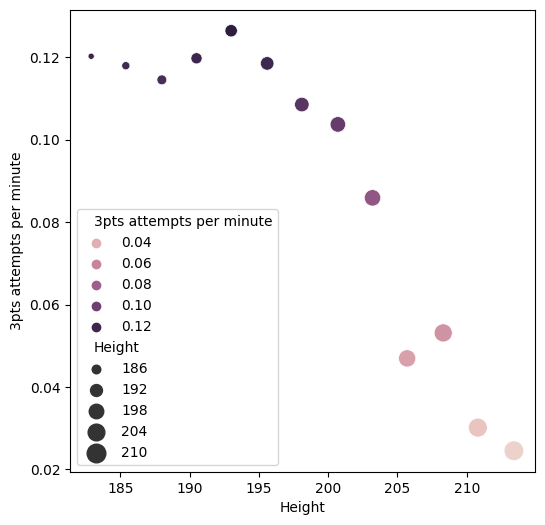

In [89]:
#fig, ax = plt.subplots(figsize=(12,4))

three_pointers_attempts_to_height = pd.pivot_table(all_seasons_per_minute, values='3PA', index='Player', columns='HT')
three_pointers_attempts_to_height = get_normalized_dataframe(three_pointers_attempts_to_height).mean()
three_pointers_attempts_to_height = pd.DataFrame(three_pointers_attempts_to_height, columns=['3pts attempts per minute'])
three_pointers_attempts_to_height.index.name = 'Height'

"""ax.plot(three_pointers_attempts_to_height.index, three_pointers_attempts_to_height.values,  marker='.')
ax.set_title('Average 3-pointers attempts for given height')
ax.set_xlabel('Height')
ax.set_xticks(three_pointers_attempts_to_height.index)"""

plt.figure(figsize=(6,6))
sns.scatterplot(
    x='Height',
    y="3pts attempts per minute",
    data=three_pointers_attempts_to_height,
    hue="3pts attempts per minute",
    size='Height',
    sizes=(20, 200),
)
plt.show()

In [31]:
players_age_height_minutes = all_seasons_per_game[['HT', 'Age', 'MPG']]
display(players_age_height_minutes)

,HT,Age,MPG
Player,,,
Tariq Abdul-Wahad,198.1,25,25.9
Shareef Abdur-Rahim,205.7,23,39.3
Cory Alexander,185.4,26,11.3
Ray Allen,195.6,24,37.4
Rafer Alston,188.0,23,13.4
...,...,...,...
Thaddeus Young,203.2,33,16.3
Trae Young,185.4,23,34.9
Omer Yurtseven,210.8,23,12.6


In [41]:
os_x1 = players_age_height_minutes['HT'].values
os_x2 = players_age_height_minutes['Age'].values
siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
mean_df = players_age_height_minutes.pivot_table(values='MPG', index='HT', columns='Age', aggfunc='mean')

def F(x):
  height, age = x
  return mean_df[height, age]

macierz_Z = np.vectorize(F)([siatka_X1, siatka_X2])
macierz_Z = np.vectorize(F)([siatka_X1, siatka_X2])

plt.imshow(macierz_Z, extent=[os_x1.min(), os_x1.max(), os_x2.min(), os_x2.max()])
plt.xticks(os_x1)
plt.yticks(os_x2)
plt.show()


TypeError: cannot unpack non-iterable numpy.float64 object

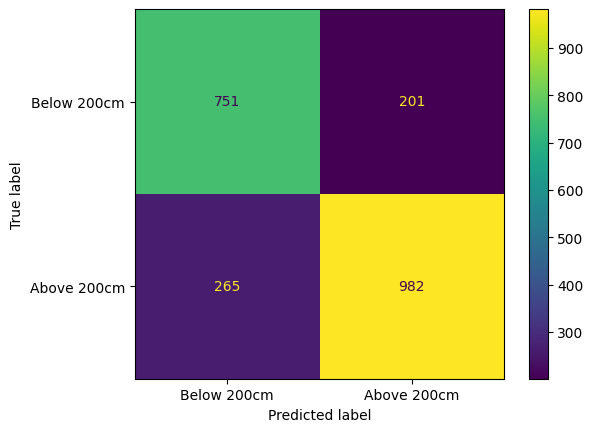

In [19]:
X = all_seasons_per_game[['FG%', '3PA', 'FT%', 'RPG', 'BPG']].values.tolist()
#'HT', 'FG%', '3PA', 'FT%', 'RPG', 'BPG'
y = [0 if ht < 200 else 1 for ht in all_seasons_per_game['HT'].values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_svm = SVC(kernel='rbf')
#svm.fit(X_train.reshape(-1,1), y_train)

sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

_svm.fit(X_train, y_train)
y_pred = _svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[_svm.classes_])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
   display_labels=["Below 200cm", "Above 200cm"],
)
disp.plot()

plt.show()

# Step 7: Predict and evaluate
#y_pred = svm.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

In [25]:
X = all_seasons_per_game[['FG%', '3PA', 'FT%', 'RPG', 'BPG']].values.tolist()
y = [0 if ht < 200 else 1 for ht in all_seasons_per_game['HT'].values.tolist()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Podstawowe parametry do modyfikacji, więcej parametrów znajdziesz na https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
C = 1.0
gamma = 10.0

X = np.array(X[::10]])
y = np.array(y[::10])
X_test = np.array([t[:2] for t in X_test[::10]])
y_test = np.array(y_test[::10])
X_train = np.array([t[:2] for t in X_train[::10]])
train = np.array(y_train[::10])

# Wygeneruj wizualizację dla każdego z modeli
for kernel in ("linear", "rbf", "poly"):
    clf = SVC(kernel=kernel, gamma=gamma, C=C)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()

    # Zwizualizuj wszystkie próbki
    plt.scatter(
        X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20
    )

    # Zaznacz okręgiem dane testowe
    plt.scatter(
        X_test[:, 0], X_test[:, 1], s=80, facecolors="none", zorder=10, edgecolor="k"
    )

    plt.axis("tight")
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Wykreśl granicę decyzyjną
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-0.5, 0, 0.5],
    )

    plt.title(kernel)
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 27)

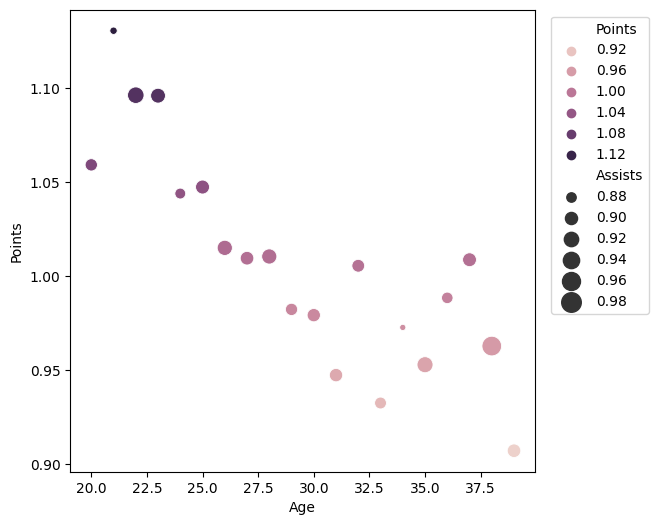

In [43]:
assists_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='AST', index='Player', columns='Age')
assists_per_minute_to_age = get_normalized_dataframe(assists_per_minute_to_age)
avrg_assists_per_minute_to_age = assists_per_minute_to_age.iloc[:, 1:].div(assists_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_assists_per_minute_to_age = avrg_assists_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()

points_per_minute_to_age = pd.pivot_table(all_seasons_per_minute, values='PTS', index='Player', columns='Age')
points_per_minute_to_age = get_normalized_dataframe(points_per_minute_to_age)
avrg_points_per_minute_to_age = points_per_minute_to_age.iloc[:, 1:].div(points_per_minute_to_age.shift(axis=1).iloc[:, 1:])
avrg_points_per_minute_to_age = avrg_points_per_minute_to_age.replace([np.inf, -np.inf], np.nan).mean()

points_assists_per_minute_to_age = pd.DataFrame({"Assists": avrg_assists_per_minute_to_age, "Points": avrg_points_per_minute_to_age})

plt.figure(figsize=(6,6))
sns.scatterplot(
    x='Age',
    y='Points',
    data=points_assists_per_minute_to_age,
    hue='Points',
    size='Assists',
    sizes=(20, 200),
)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
plt.show()

In [44]:
df = assists_per_game_to_age
ajprice = df.loc[["A.J. Price"]]
lebron = df.loc[["LeBron James"]]
display(ajprice)
display(lebron)
#ajprice.iloc[:, 1:] = ajprice.iloc[:, 1:].div(df.shift(axis=1).iloc[:, 1:])
#display(ajprice)
#df = pd.DataFrame({'A': [1, np.nan, 10, 43], 'B': [2, 2, np.nan, 10], 'C': [2, 4, 120, 160]})
# shift the dataframe one column to the right and perform the division operation
sth1 = ajprice.iloc[:, 1:].div(ajprice.shift(axis=1).iloc[:, 1:])
sth2 = lebron.iloc[:, 1:].div(lebron.shift(axis=1).iloc[:, 1:])

display(sth1)
display(sth2)

#df = df.rename(columns={df.columns[0]: 'original_column_name'})

#display(df.loc[["A.J. Price"]])
#display(df)
#print(df)

Age,19,20,21,22,23,24,25,26,27,28,...,30,31,32,33,34,35,36,37,38,39
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Price,NaN,NaN,NaN,NaN,1.9,2.2,2.0,3.6,0.5,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Age,19,20,21,22,23,24,25,26,27,28,...,30,31,32,33,34,35,36,37,38,39
Player,,,,,,,,,,,,,,,,,,,,,
LeBron James,5.9,7.2,6.6,6.0,7.2,7.2,8.6,7.0,6.2,7.3,...,7.4,6.8,8.7,9.1,8.3,10.2,7.8,6.2,NaN,NaN


Age,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Player,,,,,,,,,,,,,,,,,,,,
A.J. Price,NaN,NaN,NaN,NaN,1.157895,0.909091,1.8,0.138889,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Age,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Player,,,,,,,,,,,,,,,,,,,,
LeBron James,1.220339,0.916667,0.909091,1.2,1.0,1.194444,0.813953,0.885714,1.177419,0.863014,1.174603,0.918919,1.279412,1.045977,0.912088,1.228916,0.764706,0.794872,NaN,NaN


In [45]:
df = assists_per_game_to_age
df.iloc[:, 1:] = df.iloc[:, 1:].div(df.shift(axis=1).iloc[:, 1:])


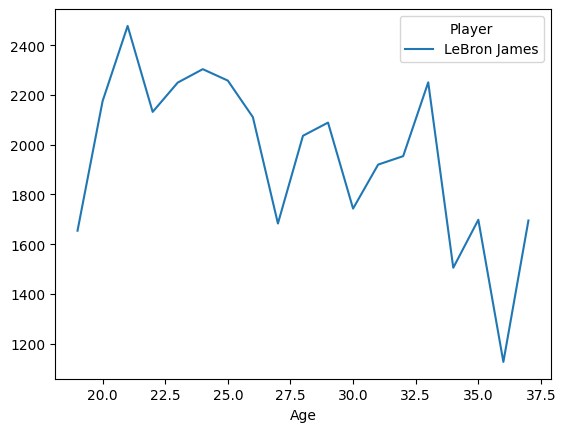

In [46]:
lebron_age_to_points = age_to_points.loc[["LeBron James"]]
lebron_age_to_points = lebron_age_to_points.transpose()
lebron_age_to_points.plot()
plt.show()

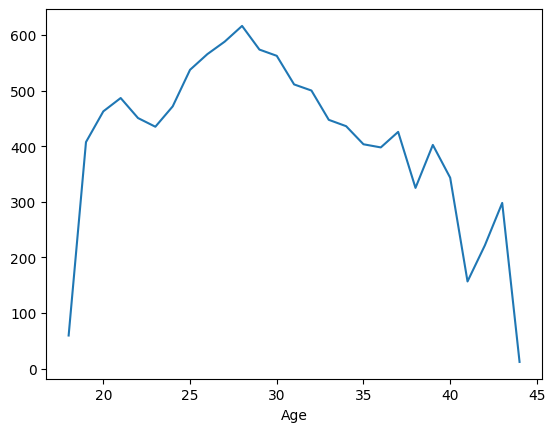

In [47]:
average_points_for_age = age_to_points.mean()
average_points_for_age.plot()
plt.show()

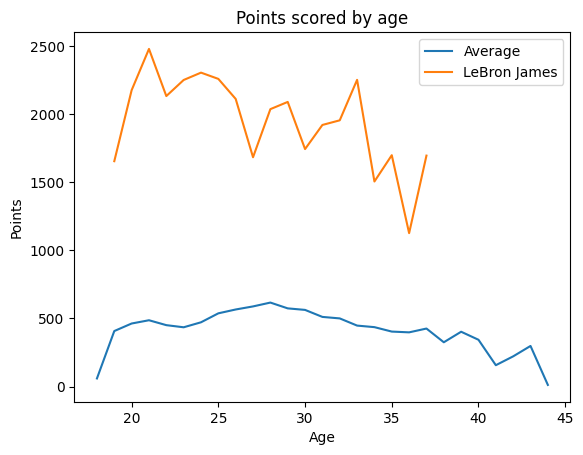

In [48]:
fig, ax = plt.subplots()
average_points_for_age = age_to_points.mean()
ax.plot(average_points_for_age.index, average_points_for_age.values, label='Average')
ax.plot(lebron_age_to_points.index, lebron_age_to_points.values, label='LeBron James')
ax.set_title('Points scored by age')
ax.set_xlabel('Age')
ax.set_ylabel('Points')
ax.legend()
plt.show()

In [49]:
average_points_for_age = age_to_points
display(average_points_for_age)
#average_points_for_age.plot()
#plt.show()

Age,18,19,20,21,22,23,24,25,26,27,...,35,36,37,38,39,40,41,42,43,44
Player,,,,,,,,,,,,,,,,,,,,,
A.C. Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,413.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Bramlett,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Guyton,NaN,NaN,NaN,NaN,NaN,198.0,244.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Hammons,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A.J. Price,NaN,NaN,NaN,NaN,NaN,410.0,323.0,172.0,441.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zion Williamson,NaN,540.0,1647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoran Dragic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zoran Planinic,NaN,NaN,NaN,153.0,217.0,191.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#merged_df = pd.merge(dataframes[0], totals_dfs[0], on='Player')

KeyError: 0

In [52]:
df_all_seasons = pd.concat([dataframes["bios", year] for year in years])
curry = df_all_seasons.loc[["Stephen Curry"]]
display(curry)

,Pos,HT,WT,Age,Teams,YOS,Pre-Draft Team,Draft Status,Nationality
Player,,,,,,,,,
Stephen Curry,G,190.5,89.8,21,GSW,0,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,22,GSW,1,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,23,GSW,2,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,24,GSW,3,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,25,GSW,4,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,26,GSW,5,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,27,GSW,6,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,28,GSW,7,Davidson,2009 Rnd 1 Pick 7,United States
Stephen Curry,G,190.5,89.8,29,GSW,8,Davidson,2009 Rnd 1 Pick 7,United States


In [53]:
df_all_seasons = pd.concat([dataframes["bios", year] for year in years])
curry = df_all_seasons.loc[["Stephen Curry", "Kevin Durant"]][["Age"]]
#curry = curry.reset_index().set_index(['Player', curry.groupby('Player').cumcount()+1])['Age'].unstack()
#curry.columns = [str(year) for year in range(2008, 2022)]
#curry.columns.name = None
display(curry)

,Age
Player,
Stephen Curry,21
Stephen Curry,22
Stephen Curry,23
Stephen Curry,24
Stephen Curry,25
Stephen Curry,26
Stephen Curry,27
Stephen Curry,28
Stephen Curry,29


In [54]:
#other = curry.pivot(index='Player', columns=curry.groupby('Player').cumcount(), values='Value')
display(dataframes["bios", 2022].loc["Stephen Curry", "Age"])

33

In [55]:
df_all_seasons = pd.concat([dataframes["bios", year] for year in years], axis=1)
curry = df_all_seasons[["Age"]]
display(curry)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
series_list = [dataframes["bios", year]['Age'] for year in years]
series_list = [s.reset_index(drop=False) for s in series_list]
result_series = pd.concat(series_list, axis=1)
pd.set_option('display.max_columns', None)
display(result_series)

In [51]:
df_all_seasons = pd.concat([dataframes["bios", year] for year in years]["Age"])
#df_player_stats = df_all_seasons.pivot(index='Player', )
#df_player_stats.columns = df_player_stats.columns.droplevel(0)
#curry = df_all_seasons.loc["Stephen Curry"]
"""df_player_stats = df_all_seasons.pivot(index='Player', columns='level_1')
df_player_stats.columns = df_player_stats.columns.droplevel(0)
display(df_player_stats)"""
pd.set_option('display.max_columns', None)
display(df_all_seasons)

<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
C:\Users\marci\AppData\Local\Temp\ipykernel_18016\3847593827.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  df_all_seasons = pd.concat([dataframes["bios", year] for year in years]["Age"])
C:\Users\marci\AppData\Local\Temp\ipykernel_18016\3847593827.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  df_all_seasons = pd.concat([dataframes["bios", year] for year in years]["Age"])
C:\Users\marci\AppData\Local\Temp\ipykernel_18016\3847593827.py:1: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  df_all_seasons = pd.concat([dataframes["bios", year] for year in years]["Age"])
C:\Users\marci\AppData\Local\Temp\ipykernel_18016\3847593827.py:1: SyntaxWar

TypeError: list indices must be integers or slices, not str

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X = all_seasons_per_game['HT'].values
#'HT', 'FG%', '3PA', 'FT%', 'RPG', 'BPG'
y = all_seasons_per_game['3PA'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm = SVC(kernel='rbf')
svm.fit(X_train.reshape(-1,1), y_train)

# Step 7: Predict and evaluate
#y_pred = svm.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

ValueError: Unknown label type: 'continuous'